## The Transformer Network for the Traveling Salesman Problem

Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code visualizes transformer and concorde solutions


In [1]:
###################
# Libs
###################

import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
try: 
    import networkx as nx
    from scipy.spatial.distance import pdist, squareform
    from concorde.tsp import TSPSolver # !pip install -e pyconcorde
except:
    pass
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
###################
# Hardware : CPU / GPU(s)
###################

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)


GPU name: GeForce GTX 1080 Ti, gpu_id: 0
cuda


In [3]:
###################
# Hyper-parameters
###################

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        
args = DotDict()
args.nb_nodes = 20 # TSP20
args.nb_nodes = 50 # TSP50
#args.nb_nodes = 100 # TSP100
args.bsz = 512 # TSP20 TSP50
args.dim_emb = 128
args.dim_ff = 512
args.dim_input_nodes = 2
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8
args.nb_epochs = 10000
args.nb_batch_per_epoch = 2500
args.nb_batch_eval = 20
args.gpu_id = gpu_id
args.lr = 1e-4
args.tol = 1e-3
args.batchnorm = True  # if batchnorm=True  than batch norm is used
#args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)


{'nb_nodes': 50, 'bsz': 512, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 2500, 'nb_batch_eval': 20, 'gpu_id': '0', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


In [ ]:
###################
# Network definition
# Notation : 
#            bsz : batch size
#            nb_nodes : number of nodes/cities
#            dim_emb : embedding/hidden dimension
#            nb_heads : nb of attention heads
#            dim_ff : feed-forward dimension
#            nb_layers : number of encoder/decoder layers
###################
def compute_tour_length(x, tour): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    bsz = x.shape[0]
    nb_nodes = x.shape[1]
    arange_vec = torch.arange(bsz, device=x.device)
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)
    previous_cities = first_cities
    L = torch.zeros(bsz, device=x.device)
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L


class Transformer_encoder_net(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes+1, nb_nodes+1) batch of attention scores
    """
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(Transformer_encoder_net, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

def myMHA(Q, K, V, nb_heads, mask=None, clip_value=None):
    """
    Compute multi-head attention (MHA) given a query Q, key K, value V and attention mask :
      h = Concat_{k=1}^nb_heads softmax(Q_k^T.K_k).V_k 
    Note : We did not use nn.MultiheadAttention to avoid re-computing all linear transformations at each call.
    Inputs : Q of size (bsz, dim_emb, 1)                batch of queries
             K of size (bsz, dim_emb, nb_nodes+1)       batch of keys
             V of size (bsz, dim_emb, nb_nodes+1)       batch of values
             mask of size (bsz, nb_nodes+1)             batch of masks of visited cities
             clip_value is a scalar 
    Outputs : attn_output of size (bsz, 1, dim_emb)     batch of attention vectors
              attn_weights of size (bsz, 1, nb_nodes+1) batch of attention weights
    """
    bsz, nb_nodes, emd_dim = K.size() #  dim_emb must be divisable by nb_heads
    if nb_heads>1:
        # PyTorch view requires contiguous dimensions for correct reshaping
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz, dim_emb, 1)
        Q = Q.view(bsz*nb_heads, emd_dim//nb_heads, 1) # size(Q)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz*nb_heads, 1, dim_emb//nb_heads)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz, dim_emb, nb_nodes+1)
        K = K.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(K)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz, dim_emb, nb_nodes+1)
        V = V.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(V)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
    attn_weights = torch.bmm(Q, K.transpose(1,2))/ Q.size(-1)**0.5 # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    if clip_value is not None:
        attn_weights = clip_value * torch.tanh(attn_weights)
    if mask is not None:
        if nb_heads>1:
            mask = torch.repeat_interleave(mask, repeats=nb_heads, dim=0) # size(mask)=(bsz*nb_heads, nb_nodes+1)
        #attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-inf')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-1e9')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_weights = torch.softmax(attn_weights, dim=-1) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_output = torch.bmm(attn_weights, V) # size(attn_output)=(bsz*nb_heads, 1, dim_emb//nb_heads)
    if nb_heads>1:
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        attn_output = attn_output.view(bsz, emd_dim, 1) # size(attn_output)=(bsz, dim_emb, 1)
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz, 1, dim_emb)
        attn_weights = attn_weights.view(bsz, nb_heads, 1, nb_nodes) # size(attn_weights)=(bsz, nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.mean(dim=1) # mean over the heads, size(attn_weights)=(bsz, 1, nb_nodes+1)
    return attn_output, attn_weights
    
    
class AutoRegressiveDecoderLayer(nn.Module):
    """
    Single decoder layer based on self-attention and query-attention
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)          batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention keys
      V_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention values
      mask of size     (bsz, nb_nodes+1)          batch of masks of visited cities
    Output :  
      h_t of size (bsz, nb_nodes+1)               batch of transformed queries
    """
    def __init__(self, dim_emb, nb_heads):
        super(AutoRegressiveDecoderLayer, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.Wq_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wk_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wv_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_att = nn.Linear(dim_emb, dim_emb)
        self.Wq_att = nn.Linear(dim_emb, dim_emb)
        self.W1_MLP = nn.Linear(dim_emb, dim_emb)
        self.W2_MLP = nn.Linear(dim_emb, dim_emb)
        self.BN_selfatt = nn.LayerNorm(dim_emb)
        self.BN_att = nn.LayerNorm(dim_emb)
        self.BN_MLP = nn.LayerNorm(dim_emb)
        self.K_sa = None
        self.V_sa = None

    def reset_selfatt_keys_values(self):
        self.K_sa = None
        self.V_sa = None
        
    # For beam search
    def reorder_selfatt_keys_values(self, t, idx_top_beams):
        bsz, B = idx_top_beams.size()
        zero_to_B = torch.arange(B, device=idx_top_beams.device) # [0,1,...,B-1]
        B2 = self.K_sa.size(0)// bsz
        self.K_sa = self.K_sa.view(bsz, B2, t+1, self.dim_emb) # size(self.K_sa)=(bsz, B2, t+1, dim_emb)
        K_sa_tmp = self.K_sa.clone()
        self.K_sa = torch.zeros(bsz, B, t+1, self.dim_emb, device=idx_top_beams.device)
        for b in range(bsz):
            self.K_sa[b, zero_to_B, :, :] = K_sa_tmp[b, idx_top_beams[b], :, :]
        self.K_sa = self.K_sa.view(bsz*B, t+1, self.dim_emb) # size(self.K_sa)=(bsz*B, t+1, dim_emb)
        self.V_sa = self.V_sa.view(bsz, B2, t+1, self.dim_emb) # size(self.K_sa)=(bsz, B, t+1, dim_emb)
        V_sa_tmp = self.V_sa.clone()
        self.V_sa = torch.zeros(bsz, B, t+1, self.dim_emb, device=idx_top_beams.device)
        for b in range(bsz):
            self.V_sa[b, zero_to_B, :, :] = V_sa_tmp[b, idx_top_beams[b], :, :]
        self.V_sa = self.V_sa.view(bsz*B, t+1, self.dim_emb) # size(self.K_sa)=(bsz*B, t+1, dim_emb)

    # For beam search
    def repeat_selfatt_keys_values(self, B):
        self.K_sa = torch.repeat_interleave(self.K_sa, B, dim=0) # size(self.K_sa)=(bsz.B, t+1, dim_emb)
        self.V_sa = torch.repeat_interleave(self.V_sa, B, dim=0) # size(self.K_sa)=(bsz.B, t+1, dim_emb)
        
    def forward(self, h_t, K_att, V_att, mask):
        bsz = h_t.size(0)
        h_t = h_t.view(bsz,1,self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # embed the query for self-attention
        q_sa = self.Wq_selfatt(h_t) # size(q_sa)=(bsz, 1, dim_emb)
        k_sa = self.Wk_selfatt(h_t) # size(k_sa)=(bsz, 1, dim_emb)
        v_sa = self.Wv_selfatt(h_t) # size(v_sa)=(bsz, 1, dim_emb)
        # concatenate the new self-attention key and value to the previous keys and values
        if self.K_sa is None:
            self.K_sa = k_sa # size(self.K_sa)=(bsz, 1, dim_emb)
            self.V_sa = v_sa # size(self.V_sa)=(bsz, 1, dim_emb)
        else:
            self.K_sa = torch.cat([self.K_sa, k_sa], dim=1)
            self.V_sa = torch.cat([self.V_sa, v_sa], dim=1)
        # compute self-attention between nodes in the partial tour
        h_t = h_t + self.W0_selfatt( myMHA(q_sa, self.K_sa, self.V_sa, self.nb_heads)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_selfatt(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # compute attention between self-attention nodes and encoding nodes in the partial tour (translation process)
        q_a = self.Wq_att(h_t) # size(q_a)=(bsz, 1, dim_emb)
        h_t = h_t + self.W0_att( myMHA(q_a, K_att, V_att, self.nb_heads, mask)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_att(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # MLP
        h_t = h_t + self.W2_MLP(torch.relu(self.W1_MLP(h_t)))
        h_t = self.BN_MLP(h_t.squeeze(1)) # size(h_t)=(bsz, dim_emb)
        return h_t
        
        
class Transformer_decoder_net(nn.Module): 
    """
    Decoder network based on self-attention and query-attention transformers
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)                            batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention keys for all decoding layers
      V_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention values for all decoding layers
      mask of size     (bsz, nb_nodes+1)                            batch of masks of visited cities
    Output :  
      prob_next_node of size (bsz, nb_nodes+1)                      batch of probabilities of next node
    """
    def __init__(self, dim_emb, nb_heads, nb_layers_decoder):
        super(Transformer_decoder_net, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.nb_layers_decoder = nb_layers_decoder
        self.decoder_layers = nn.ModuleList( [AutoRegressiveDecoderLayer(dim_emb, nb_heads) for _ in range(nb_layers_decoder-1)] )
        self.Wq_final = nn.Linear(dim_emb, dim_emb)
        
    # Reset to None self-attention keys and values when decoding starts 
    def reset_selfatt_keys_values(self): 
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].reset_selfatt_keys_values()
            
    # For beam search
    def reorder_selfatt_keys_values(self, t, idx_top_beams):
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].reorder_selfatt_keys_values(t, idx_top_beams)
    
    # For beam search
    def repeat_selfatt_keys_values(self, B):
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].repeat_selfatt_keys_values(B)
     
    def forward(self, h_t, K_att, V_att, mask):
        for l in range(self.nb_layers_decoder):
            K_att_l = K_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(K_att_l)=(bsz, nb_nodes+1, dim_emb)
            V_att_l = V_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(V_att_l)=(bsz, nb_nodes+1, dim_emb)
            if l<self.nb_layers_decoder-1: # decoder layers with multiple heads (intermediate layers)
                h_t = self.decoder_layers[l](h_t, K_att_l, V_att_l, mask)
            else: # decoder layers with single head (final layer)
                q_final = self.Wq_final(h_t)
                bsz = h_t.size(0)
                q_final = q_final.view(bsz, 1, self.dim_emb)
                attn_weights = myMHA(q_final, K_att_l, V_att_l, 1, mask, 10)[1] 
        prob_next_node = attn_weights.squeeze(1) 
        return prob_next_node


def generate_positional_encoding(d_model, max_len):
    """
    Create standard transformer PEs.
    Inputs :  
      d_model is a scalar correspoding to the hidden dimension
      max_len is the maximum length of the sequence
    Output :  
      pe of size (max_len, d_model), where d_model=dim_emb, max_len=1000
    """
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    return pe
    
    
class TSP_net(nn.Module): 
    """
    The TSP network is composed of two steps :
      Step 1. Encoder step : Take a set of 2D points representing a fully connected graph 
                             and encode the set with self-transformer.
      Step 2. Decoder step : Build the TSP tour recursively/autoregressively, 
                             i.e. one node at a time, with a self-transformer and query-transformer. 
    Inputs : 
      x of size (bsz, nb_nodes, dim_emb) Euclidian coordinates of the nodes/cities
      deterministic is a boolean : If True the salesman will chose the city with highest probability. 
                                   If False the salesman will chose the city with Bernouilli sampling.
    Outputs : 
      tours of size (bsz, nb_nodes) : batch of tours, i.e. sequences of ordered cities 
                                      tours[b,t] contains the idx of the city visited at step t in batch b
      sumLogProbOfActions of size (bsz,) : batch of sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
    """
    
    def __init__(self, dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,
                 batchnorm=True):
        super(TSP_net, self).__init__()
        
        self.dim_emb = dim_emb
        
        # input embedding layer
        self.input_emb = nn.Linear(dim_input_nodes, dim_emb)
        
        # encoder layer
        self.encoder = Transformer_encoder_net(nb_layers_encoder, dim_emb, nb_heads, dim_ff, batchnorm)
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(dim_emb))
        
        # decoder layer
        self.decoder = Transformer_decoder_net(dim_emb, nb_heads, nb_layers_decoder)
        self.WK_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.WV_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.PE = generate_positional_encoding(dim_emb, max_len_PE)        
        
    def forward(self, x, B, greedy, beamsearch):
        
        # some parameters
        bsz = x.shape[0]
        nb_nodes = x.shape[1]
        zero_to_bsz = torch.arange(bsz, device=x.device) # [0,1,...,bsz-1]
        
        # For beam search
        zero_to_B = torch.arange(B, device=x.device) # [0,1,...,B-1]

        # input embedding layer
        h = self.input_emb(x) # size(h)=(bsz, nb_nodes, dim_emb)
        
        # concat the nodes and the input placeholder that starts the decoding
        h = torch.cat([h, self.start_placeholder.repeat(bsz, 1, 1)], dim=1) # size(start_placeholder)=(bsz, nb_nodes+1, dim_emb)
        
        # encoder layer
        h_encoder, _ = self.encoder(h) # size(h)=(bsz, nb_nodes+1, dim_emb)

        # key and value for decoder    
        K_att_decoder = self.WK_att_decoder(h_encoder) # size(K_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        V_att_decoder = self.WV_att_decoder(h_encoder) # size(V_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        
        # starting node in tour
        self.PE = self.PE.to(x.device)
        
        # For beam search
        tours_greedy = torch.zeros(2, nb_nodes, device=x.device)
        tours_beamsearch = torch.zeros(2, nb_nodes, device=x.device)
        scores_greedy = torch.zeros(2, device=x.device)
        scores_beamsearch = torch.zeros(2, device=x.device)
        
        # Greedy search
        if greedy:
            #print('Greedy decoding')
            deterministic = True
            # list that will contain Long tensors of shape (bsz,) that gives the idx of the cities chosen at time t
            tours = []
            # list that will contain Float tensors of shape (bsz,) that gives the neg log probs of the choices made at time t
            sumLogProbOfActions = []
            # input placeholder that starts the decoding
            idx_start_placeholder = torch.Tensor([nb_nodes]).long().repeat(bsz).to(x.device)
            h_start = h_encoder[zero_to_bsz, idx_start_placeholder, :] + self.PE[0].repeat(bsz,1) # size(h_start)=(bsz, dim_emb)
            # initialize mask of visited cities
            mask_visited_nodes = torch.zeros(bsz, nb_nodes+1, device=x.device).bool() # False
            mask_visited_nodes[zero_to_bsz, idx_start_placeholder] = True
            # clear key and val stored in the decoder
            self.decoder.reset_selfatt_keys_values()
            # construct tour recursively
            h_t = h_start
            for t in range(nb_nodes):
                # compute probability over the next node in the tour
                prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz, nb_nodes+1)
                # choose node with highest probability or sample with Bernouilli 
                if deterministic:
                    idx = torch.argmax(prob_next_node, dim=1) # size(query)=(bsz,)
                else:
                    idx = Categorical(prob_next_node).sample() # size(query)=(bsz,)
                # compute logprobs of the action items in the list sumLogProbOfActions   
                ProbOfChoices = prob_next_node[zero_to_bsz, idx] 
                sumLogProbOfActions.append( torch.log(ProbOfChoices) )  # size(query)=(bsz,)
                # update embedding of the current visited node
                h_t = h_encoder[zero_to_bsz, idx, :] # size(h_start)=(bsz, dim_emb)
                h_t = h_t + self.PE[t+1].expand(bsz, self.dim_emb)
                # update tour
                tours.append(idx)
                # update masks with visited nodes
                mask_visited_nodes = mask_visited_nodes.clone()
                mask_visited_nodes[zero_to_bsz, idx] = True
            # logprob_of_choices = sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
            sumLogProbOfActions = torch.stack(sumLogProbOfActions,dim=1).sum(dim=1) # size(sumLogProbOfActions)=(bsz,)
            # convert the list of nodes into a tensor of shape (bsz,num_cities)
            tours = torch.stack(tours,dim=1) # size(col_index)=(bsz, nb_nodes)
            tours_greedy = tours
            scores_greedy = sumLogProbOfActions 
        
        # Beamsearch
        if beamsearch:
            #print('Beam search decoding')
            # clear key and val stored in the decoder
            self.decoder.reset_selfatt_keys_values() 
            K_att_decoder_tmp = K_att_decoder # size(K_att_decoder_tmp)=(bsz, nb_nodes, dim_emb*nb_layers_decoder)
            V_att_decoder_tmp = V_att_decoder # size(V_att_decoder_tmp)=(bsz, nb_nodes, dim_emb*nb_layers_decoder)
            for t in range(nb_nodes):
                #if not t%10:
                #    print('t: {}, GPU reserved mem: {:.2f}, GPU allocated mem: {:.2f}'.format(t,torch.cuda.memory_reserved(0)/1e9,torch.cuda.memory_allocated(0)/1e9))
                if t==0: # at t=0, there are at most B_{t=0}=nb_nodes beams
                    B_t0 = min(B, nb_nodes)
                    # input placeholder that starts the decoding
                    idx_start_placeholder = torch.Tensor([nb_nodes]).long().repeat(bsz).to(x.device)
                    h_start = h_encoder[zero_to_bsz, idx_start_placeholder, :] + self.PE[0].repeat(bsz,1) # size(h_start)=(bsz, dim_emb)
                    h_t = h_start # size(h_start)=(bsz, dim_emb)
                    mask_visited_nodes = torch.zeros(bsz, nb_nodes+1, device=x.device).bool() # False, size(mask_visited_nodes)=(bsz, nb_nodes+1) # initialize mask of visited cities
                    mask_visited_nodes[zero_to_bsz, idx_start_placeholder] = True
                    # compute probability over the next node in the tour
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz, nb_nodes+1) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, nb_nodes+1) for t=0 
                    sum_scores = score_t # size(score_t)=(bsz, nb_nodes+1)
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores, B_t0, dim=1) # size(sumScores)=(bsz, B_t0)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val # size(sumScores)=(bsz, B_t0) 
                    zero_to_B_t0 = torch.arange(B_t0, device=x.device) # [0,1,...,B_t0-1]
                    mask_visited_nodes = mask_visited_nodes.unsqueeze(1) # size(mask_visited_nodes)=(bsz, 1, nb_nodes+1)
                    mask_visited_nodes = torch.repeat_interleave(mask_visited_nodes, B_t0, dim=1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B_t0, top_idx[b]] = True # size(mask_visited_nodes)=(bsz, B_t0, nb_nodes+1)
                    tours = torch.zeros(bsz, B_t0, nb_nodes, device=x.device).long() # size(tours)=(bsz, B_t0, nb_nodes)
                    tours[:,:,t] = top_idx # size(tours)=(bsz, B_t0, nb_nodes)
                    # update embedding of the current visited node
                    h_t = torch.zeros(bsz, B_t0, self.dim_emb, device=x.device) # size(tours)=(bsz, B_t0, dim_emb)
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, top_idx[b], :] # size(h_t)=(bsz, B_t0, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B_t0, self.dim_emb) # size(h_t)=(bsz, B_t0, dim_emb)
                    self.decoder.repeat_selfatt_keys_values(B_t0)
                    K_att_decoder = torch.repeat_interleave(K_att_decoder_tmp, B_t0, dim=0) # size(K_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    V_att_decoder = torch.repeat_interleave(V_att_decoder_tmp, B_t0, dim=0) # size(V_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    
                elif t==1: # at t=1, there are at most B_{t=1}=nb_nodes^2 beams
                    # compute probability over the next node in the tour
                    h_t = h_t.view(bsz*B_t0, self.dim_emb)
                    mask_visited_nodes = mask_visited_nodes.view(bsz*B_t0, nb_nodes+1)
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz.B_t0, nb_nodes+1) 
                    prob_next_node = prob_next_node.view(bsz, B_t0, nb_nodes+1) # size(prob_next_node)=(bsz, B_t0, nb_nodes+1) 
                    mask_visited_nodes = mask_visited_nodes.view(bsz, B_t0, nb_nodes+1)
                    h_t = h_t.view(bsz, B_t0, self.dim_emb) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, B, nb_nodes+1) 
                    sum_scores = score_t + sum_scores.unsqueeze(2) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores_flatten = sum_scores.view(bsz, -1) # size(sumScores_next_node)=(bsz, B.(nb_nodes+1))
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores_flatten, B, dim=1)
                    idx_top_beams = top_idx // (nb_nodes+1) # size(idx_beam_topB)=(bsz, B)
                    idx_in_beams = top_idx - idx_top_beams* (nb_nodes+1) # size(idx_in_beams)=(bsz, B)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val
                    # update beam masks with visited nodes
                    mask_visited_nodes_tmp = mask_visited_nodes.clone() # size(mask_visited_nodes_tmp)=(bsz, B_t0, nb_nodes+1)
                    mask_visited_nodes = torch.zeros(bsz, B, nb_nodes+1, device=x.device).bool() # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, :] = mask_visited_nodes_tmp[b, idx_top_beams[b], :] # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, idx_in_beams[b]] = True # size(mask_visited_nodes)=(bsz, B, nb_nodes+1)
                    # update beam tours with visited nodes
                    tours_tmp = tours.clone()
                    tours = torch.zeros(bsz, B, nb_nodes, device=x.device).long() # size(tours)=(bsz, B, nb_nodes)
                    for b in range(bsz):
                        tours[b, zero_to_B, :] = tours_tmp[b, idx_top_beams[b], :]
                    tours[:,:,t] = idx_in_beams # size(tours)=(bsz, B, nb_nodes)
                    # update embedding of the current visited node
                    h_t = torch.zeros(bsz, B, self.dim_emb, device=x.device) # size(tours)=(bsz, B_t0, dim_emb)
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, idx_in_beams[b], :] # size(h_t)=(bsz, B, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B, self.dim_emb) # size(h_t)=(bsz, B, dim_emb)
                    # update self-attention embeddings of partial tours
                    self.decoder.reorder_selfatt_keys_values(t, idx_top_beams) # size(K_att_decoder)=(bsz*B_t0, nb_nodes+1, dim_emb*nb_layers_decoder)
                    K_att_decoder = torch.repeat_interleave(K_att_decoder_tmp, B, dim=0) # size(K_att_decoder)=(bsz*B, nb_nodes+1, dim_emb*nb_layers_decoder)
                    V_att_decoder = torch.repeat_interleave(V_att_decoder_tmp, B, dim=0) # size(V_att_decoder)=(bsz*B, nb_nodes+1, dim_emb*nb_layers_decoder)

                else: # at t>=2, we arbitrary decide to have at most B_{t>=2}=nb_nodes^2 beams
                    # compute probability over the next node in the tour
                    h_t = h_t.view(bsz*B, self.dim_emb)
                    mask_visited_nodes = mask_visited_nodes.view(bsz*B, nb_nodes+1)
                    prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz.B, nb_nodes+1) 
                    prob_next_node = prob_next_node.view(bsz, B, nb_nodes+1) # size(prob_next_node)=(bsz, B, nb_nodes+1) 
                    mask_visited_nodes = mask_visited_nodes.view(bsz, B, nb_nodes+1)
                    h_t = h_t.view(bsz, B, self.dim_emb) 
                    # compute score_t + sum_t score_{t-1} for all beams
                    score_t = torch.log(prob_next_node) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores = score_t + sum_scores.unsqueeze(2) # size(score_t)=(bsz, B, nb_nodes+1)
                    sum_scores_flatten = sum_scores.view(bsz, -1) # size(sumScores_next_node)=(bsz, B.(nb_nodes+1))
                    # choose nodes with top-B sumScores 
                    top_val, top_idx = torch.topk(sum_scores_flatten, B, dim=1)
                    idx_top_beams = top_idx // (nb_nodes+1) # size(idx_beam_topB)=(bsz, B)
                    idx_in_beams = top_idx - idx_top_beams* (nb_nodes+1) # size(idx_in_beams)=(bsz, B)
                    # update sum_t score_{t} for all beams
                    sum_scores = top_val
                    # update beam masks with visited nodes
                    mask_visited_nodes_tmp = mask_visited_nodes.clone()
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, :] = mask_visited_nodes_tmp[b, idx_top_beams[b], :]
                    for b in range(bsz):
                        mask_visited_nodes[b, zero_to_B, idx_in_beams[b]] = True
                    # update beam tours with visited nodes
                    tours_tmp = tours.clone()
                    for b in range(bsz):
                        tours[b, zero_to_B, :] = tours_tmp[b, idx_top_beams[b], :]
                    tours[:,:,t] = idx_in_beams # size(tours)=(bsz, B, nb_nodes)
                    # update embedding of the current visited node
                    for b in range(bsz):
                        h_t[b, :, :] = h_encoder[b, idx_in_beams[b], :] # size(h_t)=(bsz, B, dim_emb)
                    h_t = h_t + self.PE[t+1].expand(bsz, B, self.dim_emb) # size(h_t)=(bsz, B, dim_emb)
                    # update self-attention embeddings of partial tours
                    self.decoder.reorder_selfatt_keys_values(t, idx_top_beams)
            # sum_t log prob( pi_t | pi_0,...pi_(t-1) )
            sum_scores = sum_scores[:,0] # size(sumScores)=(bsz)
            tours_beamsearch = tours
            scores_beamsearch = sum_scores

        return tours_greedy, tours_beamsearch, scores_greedy, scores_beamsearch
    
    
    

###################
# Instantiate a training network and a baseline network
###################
try: 
    del model_baseline # remove existing model
except:
    pass

model_baseline = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, args.max_len_PE,
              batchnorm=args.batchnorm)

# # uncomment these lines if trained with multiple GPUs
# print(torch.cuda.device_count())
# if torch.cuda.device_count()>1:
#     model_baseline = nn.DataParallel(model_baseline)
# # uncomment these lines if trained with multiple GPUs

model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')



###################
# Load checkpoint
###################
checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl" 
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
model_baseline.load_state_dict(checkpoint['model_baseline'])
print('Load checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
del checkpoint

mystring_min = 'Epoch: {:d}, tot_time_ckpt: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}\n'.format(
    epoch_ckpt, tot_time_ckpt/3660/24, plot_performance_train[-1][1], plot_performance_baseline[-1][1]) 
print(mystring_min) 


GPU reserved mem: 0.55, GPU allocated mem: 0.53
L_greedy tensor([5.6318, 5.3691, 5.7799, 6.1321], device='cuda:0')
L_beamsearch tensor([5.5829, 5.3427, 5.7791, 6.1253], device='cuda:0')
L_concorde tensor([5.5829, 5.3429, 5.7791, 6.1264])
Concorde time: 0.269sec
gap: -5.6862831115722656e-05


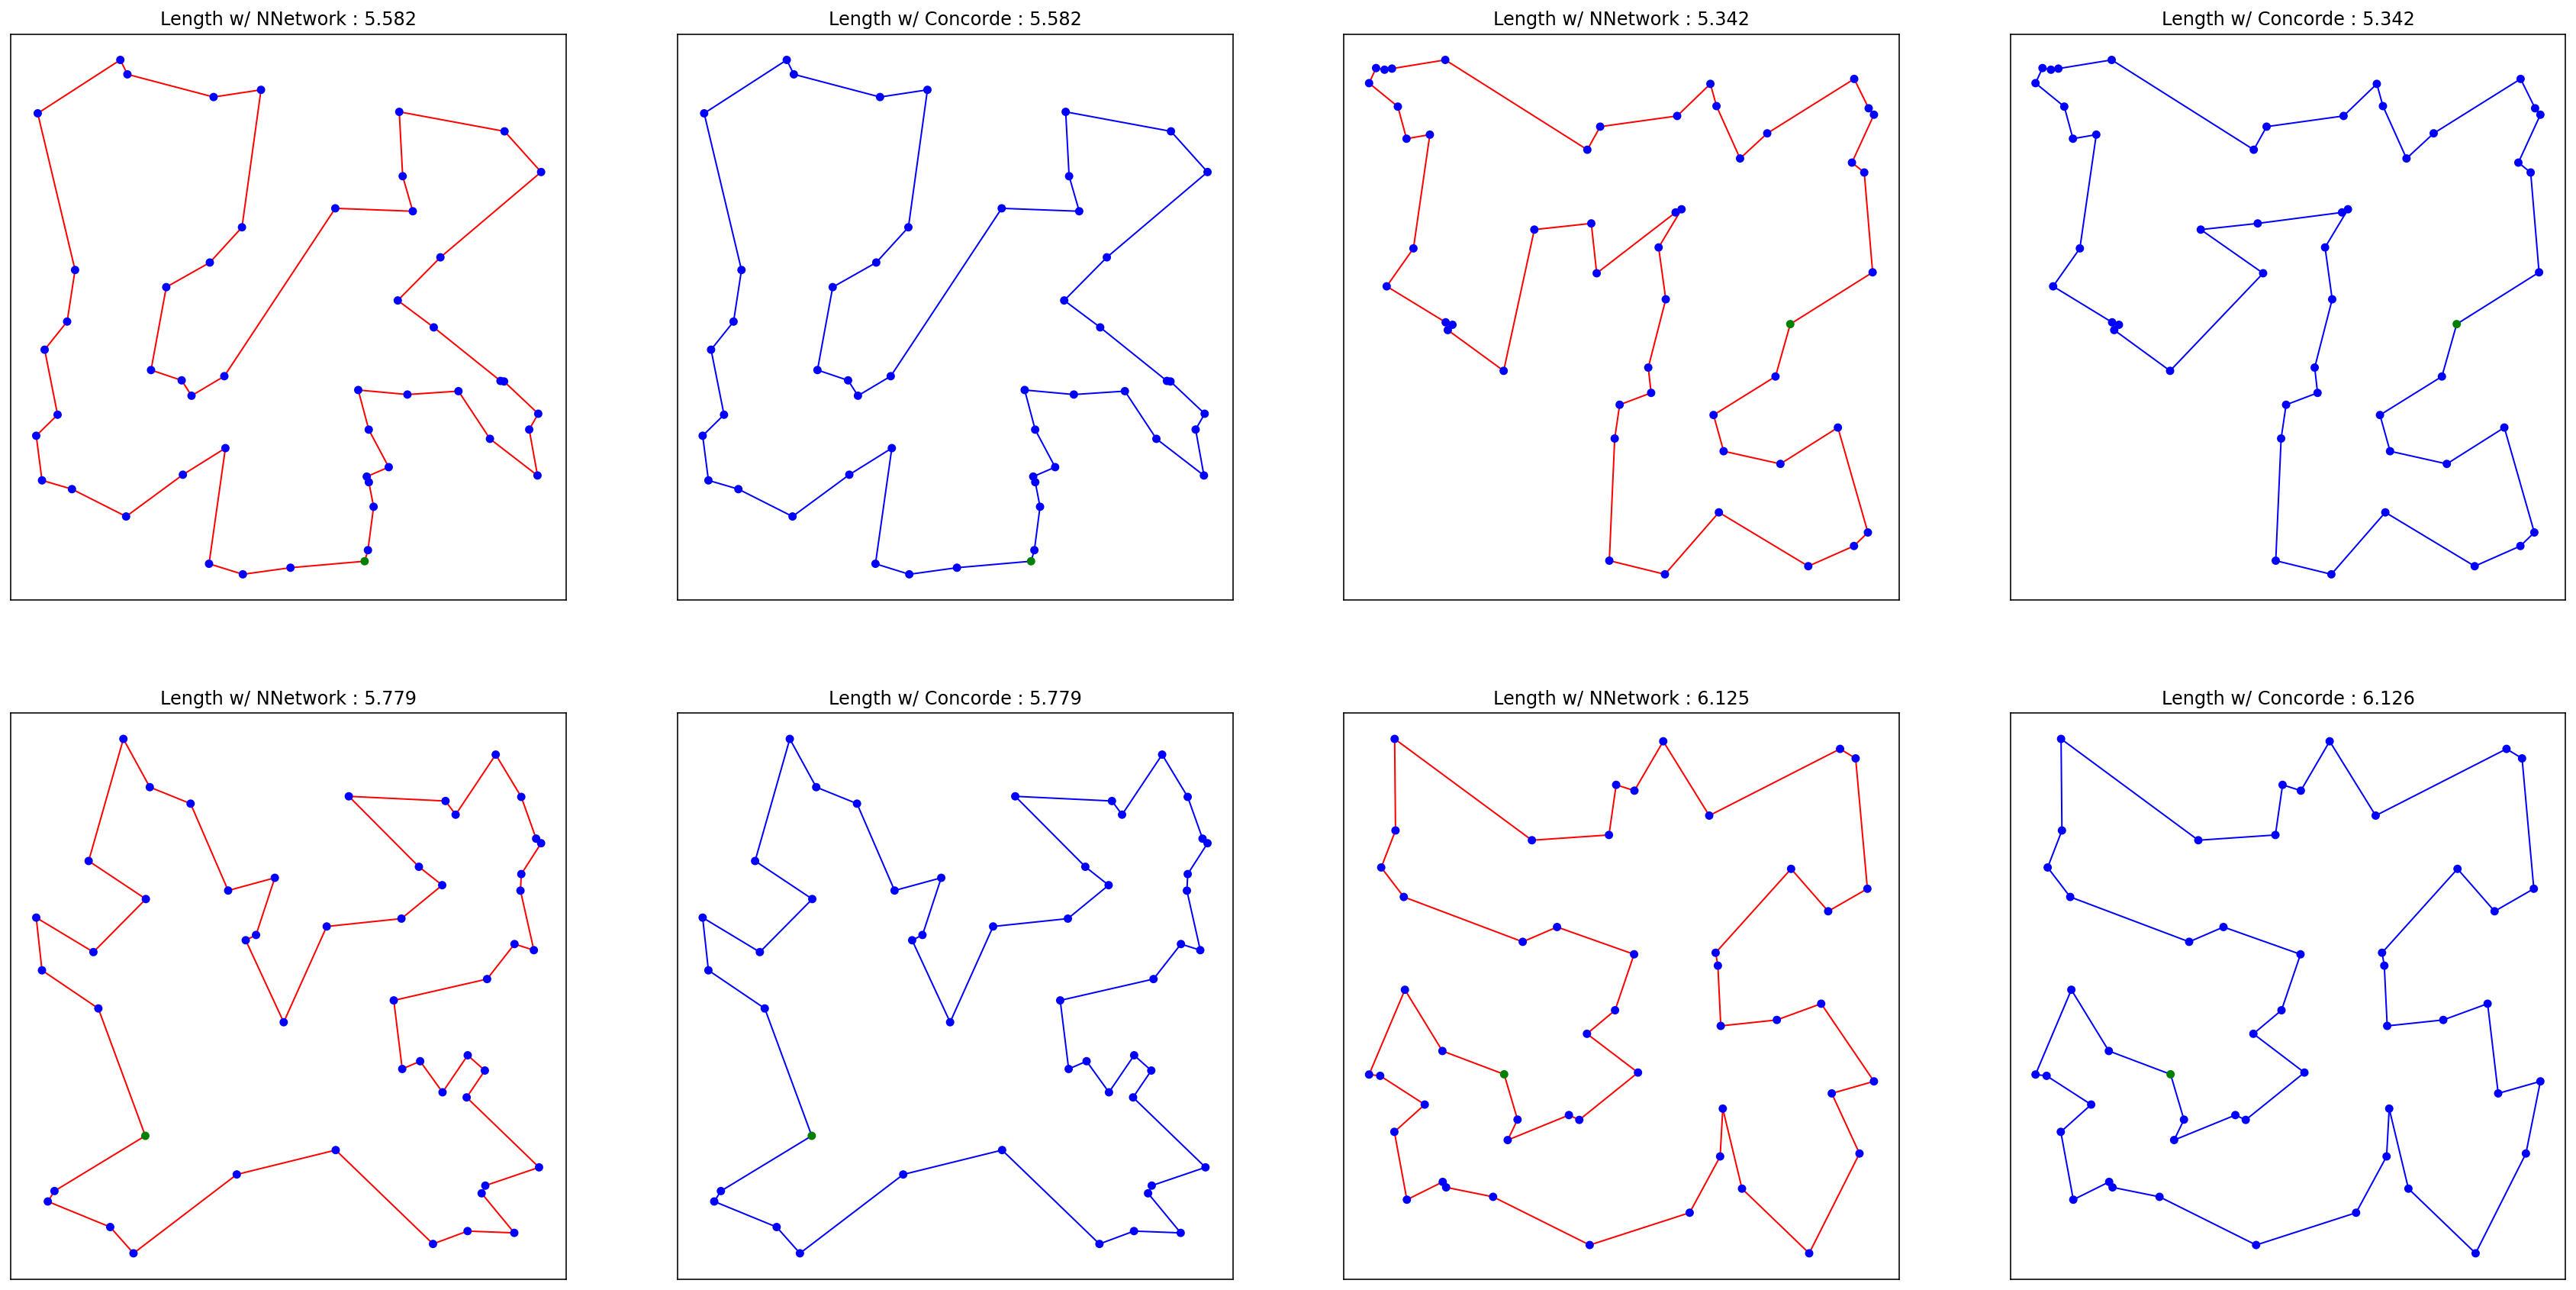

In [8]:
   
def plot_tsp(x_coord, x_path, plot_concorde=False, plot_dist_pair=False):
    """
    Helper function to plot TSP tours.
    """

    # pytorch detach
    x_coord = x_coord.detach().cpu()
    x_path = x_path.detach().cpu()
    
    # compute TSP lengths
    length_tsp = compute_tour_length(x_coord, x_path)
    
    # preparation  
    x_coord = np.array(x_coord)
    x_path = np.array(x_path)
    nb_nodes = x_coord.shape[1]
    G = nx.from_numpy_matrix(np.zeros((nb_nodes,nb_nodes)))
    colors = ['g'] + ['b'] * (nb_nodes - 1)  # Green for 0th node, blue for others
    batch_size = x_coord.shape[0]
    max_nb_plots = 3**2 # max number of TSP plots, x^2 for x rows and x cols 
    nb_plots = batch_size if batch_size<max_nb_plots else max_nb_plots 
    nb_rows = nb_cols = int(nb_plots**0.5)
    if plot_concorde: nb_cols *= 2 # double nb of cols if concorde is plotted 
    f = plt.figure(figsize=(30, 15)) if plot_concorde else plt.figure(figsize=(15, 15)) # figure size  
    
    # gap
    running_time = 0
    gap = 0
    L_concorde = []
    
    # loop over TSPs
    for i in range(nb_plots):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i.tolist()))
        if plot_dist_pair: # Compute pairwise distances matrix for better visualization
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean')) 
            G = nx.from_numpy_matrix(dist_pair_i)
        x_path_i = x_path[i] 
        length_tsp_i = length_tsp[i]
        nodes_pair_tsp_i = []
        for r in range(nb_nodes-1): # compute consecutive nodes in the solution
            nodes_pair_tsp_i.append((x_path_i[r], x_path_i[r+1]))
        nodes_pair_tsp_i.append((x_path_i[nb_nodes-1], x_path_i[0]))
        if plot_concorde: # run concorde solver
            start = time.time()
            graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
            solver = TSPSolver.from_data( graph.lat, graph.lon, norm="GEO" )  
            solution = solver.solve().tour
            running_time += time.time()-start
            nodes_pair_concorde_i = []
            for r in range(nb_nodes-1):
                nodes_pair_concorde_i.append((solution[r], solution[r+1]))
            nodes_pair_concorde_i.append((solution[nb_nodes-1], solution[0]))
            length_concorde = compute_tour_length(torch.tensor(x_coord_i).unsqueeze(0),torch.tensor(solution).long().unsqueeze(0))
            gap += length_tsp_i/length_concorde - 1.0
            L_concorde.append(length_concorde)
        if plot_concorde:
            subf = f.add_subplot(nb_rows,nb_cols,2*i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
            subf = f.add_subplot(nb_rows,nb_cols,2*i+2)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_concorde_i, alpha=1, width=1, edge_color='b') #, style='dashed'
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ Concorde : ' + str(length_concorde.item())[:5])
        else:
            subf = f.add_subplot(nb_rows,nb_cols,i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
       
    L_concorde = torch.stack(L_concorde).squeeze()
    print('L_concorde',L_concorde)
    
    # gap
    if plot_concorde:
        print('Concorde time: {:.3f}sec'.format(running_time))  
        print('gap:',(gap/nb_plots).item())



    
bsz = 4
    
nb_nodes = 50; B = 2500; greedy = False; beamsearch = True 
# nb_nodes = 100; B = 100
# nb_nodes = 100; B = 1000
# nb_nodes = 100; B = 3000
# nb_nodes = 200; B = 100
# nb_nodes = 200; B = 1000

x = torch.rand(bsz, nb_nodes, 2)
x = x.to(device)


with torch.no_grad():
    tours_greedy, tours_beamsearch, scores_greedy, scores_beamsearch = model_baseline(x, B, True, True)
    # greedy
    L_greedy = compute_tour_length(x, tours_greedy)
    mean_tour_length_greedy = L_greedy.mean().item()  
    mean_scores_greedy = scores_greedy.mean().item()    
    # beamsearch
    tours_beamsearch = tours_beamsearch.view(bsz*B, nb_nodes)
    x_beamsearch = x.repeat_interleave(B,dim=0)
    L_beamsearch = compute_tour_length(x_beamsearch, tours_beamsearch)
    L_beamsearch = L_beamsearch.view(bsz, B)
    L_beamsearch, idx_min = L_beamsearch.min(dim=1)
    tours_beamsearch = tours_beamsearch.view(bsz, B, nb_nodes)
    torch.cuda.empty_cache() # free GPU reserved memory 
    print('GPU reserved mem: {:.2f}, GPU allocated mem: {:.2f}'.format(torch.cuda.memory_reserved(0)/1e9,torch.cuda.memory_allocated(0)/1e9))

print('L_greedy',L_greedy)
print('L_beamsearch',L_beamsearch)

tours = []
for b in range(bsz):
    tours.append(tours_beamsearch[b,idx_min[b],:])
tours_beamsearch = torch.stack(tours, dim=0)

#plot_tsp(x, tours_greedy, plot_concorde=True)
plot_tsp(x, tours_beamsearch, plot_concorde=True)

